In [ ]:
from psrpop import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


def SampleDistance(A, B):
    means_A = A.mean(axis=0)
    vars_A = A.var(axis=0) / 2

    A = (A - means_A) / vars_A
    B = (B - means_A) / vars_A

    nA = len(A)
    nB = len(B)

    diffAB = cdist(A, B).sum()
    diffAA = cdist(A, A).sum()
    diffBB = cdist(B, B).sum()

    return (
        (nA + nB)
        / (nA * nB)
        * (2 * diffAB / (nA * nB) - diffAA / nA**2 - diffBB / nB**2)
    )


def IsNormalPulsar(Ps, Pdots):
    # criterion ms-pulsars

    P1_lower, Pdot1_lower = 0.01, 1e-10  # (P, Pdot)
    P2_lower, Pdot2_lower = 1.0, 1e-19  # (P, Pdot)

    logP1_lower, logPdot1_lower = np.log10(P1_lower), np.log10(Pdot1_lower)
    logP2_lower, logPdot2_lower = np.log10(P2_lower), np.log10(Pdot2_lower)

    slope_lower = (logPdot2_lower - logPdot1_lower) / (logP2_lower - logP1_lower)
    intercept_lower = logPdot1_lower - slope_lower * logP1_lower

    P_line_lower = np.logspace(np.log10(P1_lower), np.log10(P2_lower), 100)
    Pdot_line_lower = 10 ** (slope_lower * np.log10(P_line_lower) + intercept_lower)

    # criterion magnetars

    P1_upper, Pdot1_upper = 0.1, 1e-10
    P2_upper, Pdot2_upper = 10.0, 1e-14

    logP1_upper, logPdot1_upper = np.log10(P1_upper), np.log10(Pdot1_upper)
    logP2_upper, logPdot2_upper = np.log10(P2_upper), np.log10(Pdot2_upper)

    slope_upper = (logPdot2_upper - logPdot1_upper) / (logP2_upper - logP1_upper)
    intercept_upper = logPdot1_upper - slope_upper * logP1_upper

    return (Pdots < 10 ** (slope_upper * np.log10(Ps) + intercept_upper)) & (
        Pdots > 10 ** (slope_lower * np.log10(Ps) + intercept_lower)
    )

Task:
1. Pack the $P$ and $\dot{P}$ into a 2D array and pass to the `SampleDistance` function to get a measure of how similar the distributions are.
2. Plot how that value changes for different values of `nbraking` and/or `beta`.

In [111]:
pulsars = Simulate_Evolution(
    birth_rate=0.2 / 100,
    total_time=1e8,
    nbraking=2.5,
    beta=0.05,
)

In [3]:
catalog = Read_Catalogue()

In [112]:
detectable_pulsars = pulsars.select(Detectable_Geometric).select(Detectable_Radioflux)

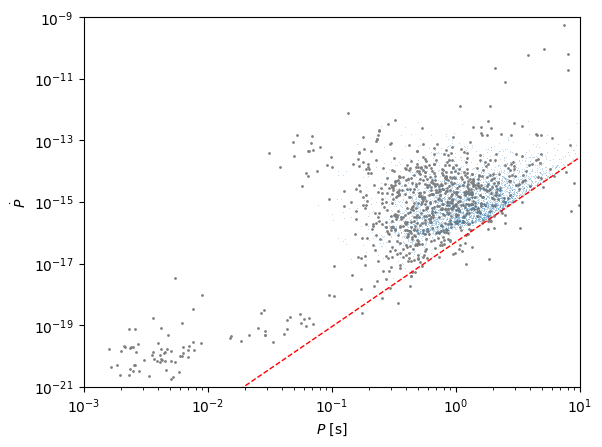

In [103]:
ax = Plot_PPdot(detectable_pulsars, color=None, s=0.1, lw=0)

ax.scatter(
    catalog.P0.astype(float),
    catalog.P1.astype(float),
    s=1,
    color="gray",
    zorder=-1,
)

In [ ]:
# pack the data into 2D arrays

real_pulsars_P = np.array(catalog["P0"], dtype=float)
real_pulsars_Pdot = np.array(catalog["P1"], dtype=float)
# real_pulsars_Dist = np.array(catalog["DIST_DM"], dtype=float)

# mask out the nan and negative values
mask = (
    ~np.isnan(real_pulsars_P)
    & ~np.isnan(real_pulsars_Pdot)
    & ~np.isnan(real_pulsars_Dist)
    & (real_pulsars_P > 0)
    & (real_pulsars_Pdot > 0)
    # & (real_pulsars_Dist > 0)
    & IsNormalPulsar(real_pulsars_P, real_pulsars_Pdot)
)

real_pulsars = np.array(
    [
        np.log(real_pulsars_P[mask]),
        np.log(real_pulsars_Pdot[mask]),
        # real_pulsars_Dist[mask],
    ]
).T
synthetic_pulsars = np.array(
    [
        np.log(detectable_pulsars.Ps),
        np.log(detectable_pulsars.Pdots),
        # detectable_pulsars.distances,
    ]
).T

In [129]:
SampleDistance(real_pulsars, synthetic_pulsars)

np.float64(0.0011226757928086792)